# Basic Portfolio Analysis

#### Notebook: Initial Descriptive Analysis


In [1]:
# standard python libraries
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from forex_python.converter import CurrencyRates

# library for getting historical stock price data
import fastquant as fq
import yfinance as yf


# Part 1: Collecting the Data

### While the initial idea is to find a way to mine historical stock prices data using the `Fastquant` package, the `Fastquant` package cannot retrieve most of the historical data. Hence, the historical data was collected manually from the `https://ph.investing.com/` website.

In [2]:
stocks_df = pd.DataFrame()

for file in glob.glob('data/20230315/stocks/*'):
    stock_df = pd.read_csv(file, index_col=[0])
    stock_name = os.path.basename(file)[:-4]
    stock_df.rename({'Price':stock_name}, axis=1, inplace=True)
    stock_df = stock_df[[stock_name]].copy()
    if stocks_df.empty:
        stocks_df = stock_df.copy()
    else:
        stocks_df = stocks_df.join(stock_df, how='outer')

stocks_df.reset_index(inplace=True)
stocks_df.Date = pd.to_datetime(stocks_df.Date)
stocks_df.sort_values('Date',inplace=True)
stocks_df.set_index('Date',inplace=True)


In [3]:
stocks_df.GLO = stocks_df.GLO.str.replace(',','').astype(float)
stocks_df.TEL = stocks_df.TEL.str.replace(',','').astype(float)

In [4]:
stocks_df[['AREIT','CNVRG','RCR','SMC2I', 'CREIT']] = stocks_df[['AREIT','CNVRG','RCR','SMC2I','CREIT']].fillna(0)
stocks_df['FPH'].ffill(inplace=True)
stocks_df['AEV'].bfill(inplace=True)

# Part 2: Data Preprocessing

## 2.1 Converting prices to returns

#### Many models are approaches used for time series modelling require the time series to be stationary. Stationarity assumes that the statistics of a process do not change over times. Using that assumption, we can build models that aim to forecast the future value of the process.

#### However, asset prices are usually non-stationary. Their statistic not only change over time, but we can also observe some trends (general patterns over time) or seasonality (patterns repeating over fixed time intervals). By transforming the prices into returns, we attempt to make the time series stationary. 

#### Another benefits of using returns, as opposed to prices, is normalization. It means that we can easily compare various return series, which would not be that simple with raw staock prices.

##### There are two types of returns.
<ol>
<li>Simple Returns
<li>Log Returns
</ol>
 

In [5]:
stocks_simple_rtn_df = stocks_df.pct_change().fillna(0,)
stocks_log_rtn_df = np.log(stocks_df/stocks_df.shift(1)).fillna(0)

In [6]:
stocks_simple_rtn_df.head()

,AREIT,MER,CNVRG,SECB,DNL,MBT,ICT,BPI,CREIT,FPH,RCR,SMC2I,GLO,CNPF,TEL,AEV
Date,,,,,,,,,,,,,,,,
2019-01-02,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2019-01-03,0.0,0.014061,0.0,0.038148,0.020009,0.031694,0.005027,0.010638,0.0,0.000000,0.0,inf,-0.005789,0.032035,0.024779,0.0
2019-01-04,0.0,0.010248,0.0,0.017456,0.001800,0.000000,-0.010003,-0.015789,0.0,0.020866,0.0,0.013793,-0.008999,0.015454,0.001727,0.0
2019-01-07,0.0,-0.033495,0.0,0.000622,0.014282,-0.024843,0.010104,-0.005348,0.0,0.021953,0.0,-1.000000,-0.006410,0.003821,-0.010345,0.0
2019-01-08,0.0,0.003141,0.0,0.000621,-0.006996,-0.021230,-0.010999,-0.012903,0.0,0.000000,0.0,0.000000,0.000000,-0.011355,-0.006969,0.0


## 2.2 Adjusting the returns for inflation

#### Inflation might have to be incorporated when doing long-term analysis. Inflation is the lowering of a currency's purchasing power over time. Hence it might important to discount the power of money depending on the inflation rate.


#### For this we can focus on adjusting the returns by calculating real returns.

$$
  R_{t}^r = \frac{1+R_{t}}{1+\pi_{t}} - 1
$$

where $R_{t}^r$ is the real return, $R_{t}$ is the time t simple return, and $\pi_{t}$ is inflation

<br><br>

In this case, inflation was collected from the `BSP` website.

In [7]:
inf_df = pd.read_excel('data/bsp/prices2018.xls',sheet_name='Monthly',header=[6],usecols=range(1,4))
inf_df = inf_df.loc[:inf_df[inf_df.Year == 'Year'].index[0]-3,:]
inf_df.dropna(axis=0, inplace=True)
inf_df['Date'] = pd.to_datetime(inf_df['Month'].astype(str) + ' ' + inf_df['Year'].astype(str), format = '%b %Y')
inf_df = inf_df[['Date','All Items']]
inf_df.rename({'All Items':'CPI'},axis=1,inplace=True)
inf_df.set_index('Date', inplace=True)

#### Now, let us merge the two dataframes.

In [8]:
stocks_df = stocks_df.join(inf_df,how='outer')
stocks_df = stocks_df.query('"2019-01-01" <= index')
stocks_df['CPI'].ffill(inplace=True)
stocks_df.ffill(inplace=True)
stocks_df.bfill(inplace=True)

In [9]:
stocks_df

,AREIT,MER,CNVRG,SECB,DNL,MBT,ICT,BPI,CREIT,FPH,RCR,SMC2I,GLO,CNPF,TEL,AEV,CPI
Date,,,,,,,,,,,,,,,,,
2019-01-01,0.00,376.23,0.00,152.30,10.895,72.57,97.877,94.0,0.00,64.70,0.00,0.0,1900.0,14.734,1130.0,64.80,101.5
2019-01-02,0.00,376.23,0.00,152.30,10.895,72.57,97.877,94.0,0.00,64.70,0.00,0.0,1900.0,14.734,1130.0,64.80,101.5
2019-01-03,0.00,381.52,0.00,158.11,11.113,74.87,98.369,95.0,0.00,64.70,0.00,72.5,1889.0,15.206,1158.0,64.80,101.5
2019-01-04,0.00,385.43,0.00,160.87,11.133,74.87,97.385,93.5,0.00,66.05,0.00,73.5,1872.0,15.441,1160.0,64.80,101.5
2019-01-07,0.00,372.52,0.00,160.97,11.292,73.01,98.369,93.0,0.00,67.50,0.00,0.0,1860.0,15.500,1148.0,64.80,101.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,34.95,314.00,15.72,101.00,7.860,60.10,212.400,108.0,2.45,61.95,5.65,74.8,1800.0,26.000,1280.0,51.45,121.4
2023-03-10,34.80,320.00,15.50,99.00,7.790,59.70,213.000,109.0,2.42,62.20,5.60,74.8,1820.0,25.450,1316.0,50.30,121.4
2023-03-13,34.40,317.80,15.04,94.10,7.690,59.40,207.400,105.1,2.42,61.95,5.58,74.8,1800.0,25.600,1278.0,52.50,121.4


## 2.2 Changing the frequency of time series data

In [10]:
stocks_returns_df = {}

for idx, stock in enumerate(stocks_df.columns):
    if stock == 'CPI':
        pass
    else:
        temp_df = stocks_df[[stock,'CPI']].copy()
        temp_df["simple_rtn"] = temp_df[stock].pct_change()
        temp_df["inflation_rate"] = temp_df["CPI"].pct_change()
        temp_df["real_rtn"] = ((temp_df["simple_rtn"] + 1) / (temp_df["inflation_rate"] + 1) - 1)
        temp_df['log_rtn'] = np.log(temp_df[stock]/temp_df[stock].shift(1)).fillna(0)
        temp_df.fillna(0, inplace=True)
        stocks_returns_df[stock] = temp_df


#### The general rule of thumb for changing frequency can be broken down into the following:

<ul>
<li>Multiply/divide the log returns by the number of time periods.
<li>Multiply/divide the volatility by the square root of the number of time periods.
</ul>

$$
  RV = \sqrt{\sum_{i=1}^{T}r_{t}^2}
$$

Realized volatility refers to the measure of daily changes in the price of a security over a particular period of time. Realized volatility is frequently used for calculating the daily volatility using intraday returns. 

The steps we need to take are as follows:
<ul><li>Download the data and calculate the log returns
<li>Calculate the realized volatility over the months
<li>Annualize the values by multiplying by √12, as we are converting from monthly values
</ul>

1. Define the function for calculating the realized volatility

In [11]:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

2. Calculate the monthly realized volatility

In [12]:
stocks_rv_df = {}

for key, values in stocks_returns_df.items():
    stocks_rv_df[key] = (
    values.groupby(pd.Grouper(freq="M"))
    .apply(realized_volatility)
    .rename(columns={"log_rtn": "realized volatility"})
)

stocks_rv_df['MER'].head()

,MER,CPI,simple_rtn,inflation_rate,real_rtn,realized volatility
Date,,,,,,
2019-01-31,1787.684935,486.776900,0.080903,0.000000,0.080903,0.081189
2019-02-28,1521.093880,431.052294,0.061561,0.000985,0.061356,0.061512
2019-03-31,1685.475440,466.047948,0.064372,0.000984,0.064405,0.064272
2019-04-30,1622.660334,444.607692,0.048894,0.002950,0.048178,0.048710
2019-05-31,1716.948745,479.360491,0.074669,0.001961,0.074695,0.074065


3. Annualize the values

In [13]:
for key, values in stocks_rv_df.items():
    values['realized volatility'] = values['realized volatility'] * np.sqrt(12)
    values.to_csv(f'data/output/{key}.csv')

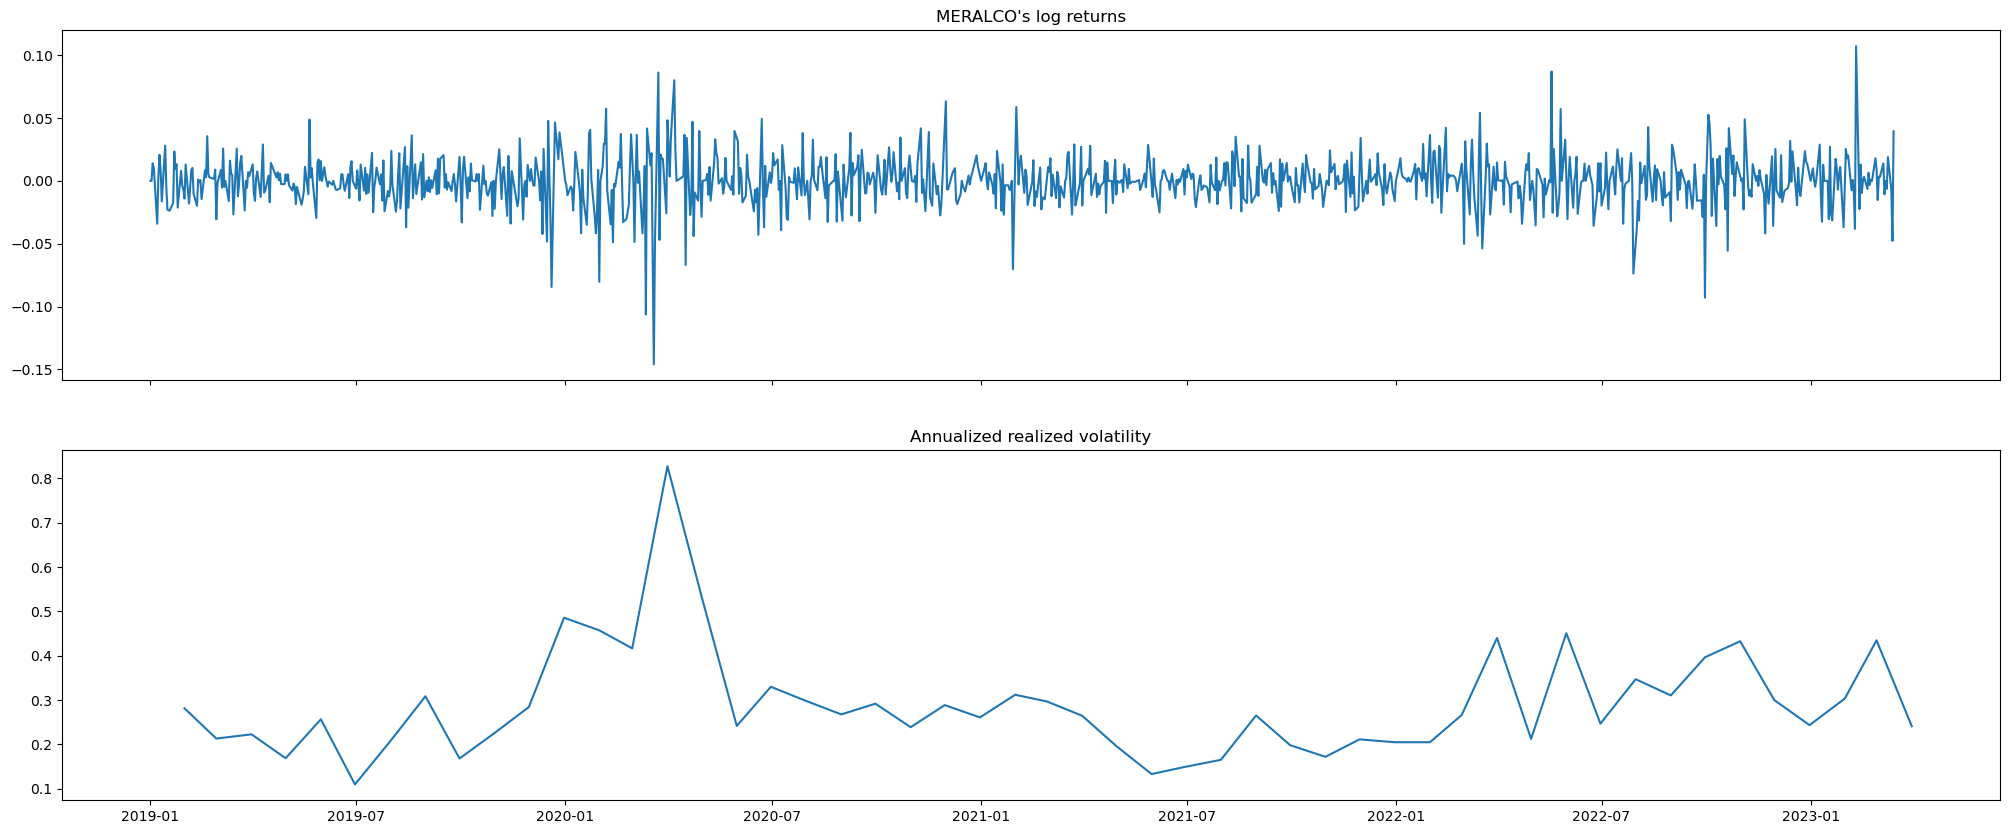

In [391]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(25,10))
ax[0].plot(meralco.log_rtn)
ax[0].set_title("MERALCO's log returns")
ax[1].plot(meralco_rv.rv)
ax[1].set_title("Annualized realized volatility")
plt.show()

In [393]:
#### how to download FX data
df = yf.download("USDPHP=X",
                 start=meralco.index[0],
                 end=meralco.index[-1],
                 progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,52.490002,52.490002,52.030998,52.490002,52.490002,0
2019-01-02,52.419998,52.632999,52.095001,52.470001,52.470001,0
2019-01-03,52.540001,52.757999,52.306000,52.549999,52.549999,0
2019-01-04,52.570000,52.639999,51.970001,52.570000,52.570000,0
2019-01-07,52.380001,52.480000,52.234001,52.380001,52.380001,0
